# Figure 4

## Imports

In [27]:
import matplotlib.pyplot as plt
import numpy
import os
import copy
import shutil

import dolfin_mech                    as dmech


## Creating folder for temporary files

In [28]:
current_directory=os.getcwd()
new_directory="calc_fig4"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

In [29]:
alpha = 0.16
gamma = 0.5
c1 = 1.2
c2 = 0. ## obsolete parameter
rho_solid =  1.06e-6


params = {
        "alpha": alpha,
        "gamma":gamma,
        "c1":c1,
        "c2":c2,
        "kappa":1e2,
        "eta":1e-5,
        "rho_solid":rho_solid}

mat_params = {"scaling":"linear", "parameters": params}

## Loading

In [30]:
pe, pi = -0.5, -2. ### pleural pressure values 

gravity_lst = [0., 1.] ### 0 = without gravity, 1 = with gravity

## Mesh

In [31]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf", "refine": True}

### the mesh is refined only for plotting purposes


## Computing end-exhalation and end-inhalation porosities with and without gravity

In [32]:
for gravity_ in gravity_lst:
    coef = -1.*gravity_ ##### -1 because gravity is applied from top to bottom
    load_params_inverse = {
        "type":"p_boundary_condition0", "f":coef*9.81e3, "P0" : float(pe)}
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f":coef*9.81e3, "P0" : float(pe)}
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f":coef*9.81e3, "P0" : float(pi)}
    

    ##### computing the reference configuration, trough an inverse problem
    Uref, phisref_computation, Vexpiini, Vref = dmech.run_RivlinCube_PoroHyperelasticity(
            inverse=1,
            mat_params=mat_params,
            load_params=load_params_inverse,
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":1},
            res_basename=res_basename+"/reference",
            cube_params=cube_params,
            verbose=1)
    

    ##### assuming that porosity is uniform in the unloaded configuration, and taking the same starting values for the problem with and the problem without gravity 


    if gravity_ == 0.:
        phisref_imposed=[numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]
        Uexhal, phisexhal_g0, Vunloaded, Vexhal = dmech.run_RivlinCube_PoroHyperelasticity(
                    porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                    mat_params=mat_params,
                    load_params=load_params_direct_exhalation,
                    res_basename=res_basename+"/exhalation",
                    get_results=1,
                    inertia=1,
                    step_params={"dt_min":1e-4, "dt_ini":0.125},
                    cube_params=cube_params,
                    move = {"move":True, "U":Uref},
                    verbose=1)
    else:
        Uexhal, phisexhal_g, Vunloaded, Vexhal = dmech.run_RivlinCube_PoroHyperelasticity(
                    porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
                    mat_params=mat_params,
                    load_params=load_params_direct_exhalation,
                    res_basename = res_basename+"/exhalation",
                    get_results=1,
                    inertia=1,
                    step_params={"dt_min":1e-4, "dt_ini":0.125},
                    cube_params=cube_params,
                    move = {"move":True, "U":Uref},
                    verbose=1)
        

    Uinhal, phisinhal, Vunloaded, Vinhal = dmech.run_RivlinCube_PoroHyperelasticity(
            porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
            mat_params=mat_params,
            load_params=load_params_direct_inhalation,
            res_basename = res_basename+"/inhalation",
            move = {"move":True, "U":Uref},
            get_results=1,
            inertia=1,
            step_params={"dt_min":1e-4, "dt_ini":0.125},
            cube_params=cube_params,
            verbose=1)
    
    if gravity_ == 0.:
        phisinhal_g0 = copy.deepcopy(phisinhal)

Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points


In [33]:
if clean_upon_completion:
    shutil.rmtree(res_basename, ignore_errors=1)

## Post-processing

### Computing frequency of appearance of the different porosities

In [34]:
porosity_exhal_g0=[]
porosity_inhal_g0=[]
porosity_exhal_g=[]
porosity_inhal_g=[]
porosity_ref=[]

# phisexhal_g0=phisexhal_g0.tolist()
# phisinhal_g0=phisinhal_g0.tolist()
# phisexhal_g=phisexhal_g.tolist()
# phisinhal=phisinhal.tolist()


porosity_lst = numpy.linspace(0, 1, 300)


#### value from calculations: phis, porosity = phif-phis
porosity_plot = []


#### plotting phif = 1 - phis


for c in range(0, len(porosity_lst)-1):
    min = porosity_lst[c]
    max = porosity_lst[c+1]
    porosity_exhal_g0.append(numpy.sum([min<=i<max for i in phisexhal_g0]))
    porosity_inhal_g0.append(numpy.sum([min<=i<max for i in phisinhal_g0]))
    porosity_exhal_g.append(numpy.sum([min<=i<max for i in phisexhal_g]))
    porosity_inhal_g.append(numpy.sum([min<=i<max for i in phisinhal]))
    porosity_ref.append(numpy.sum([min<=i<max for i in phisref_imposed]))
    porosity_plot.append(1-(min+(max-min)/2))

## Generating plots

### End-exhalation

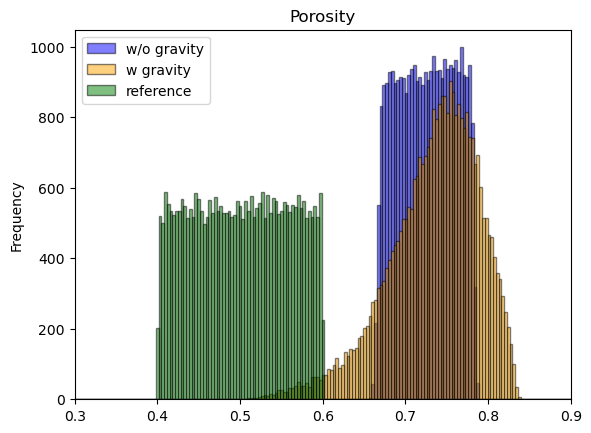

In [35]:
fig, ax = plt.subplots()

width=max-min

# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']


ax.bar(porosity_plot, porosity_exhal_g0, color='blue', label='w/o gravity', alpha=0.5, edgecolor='black', width=width) #, label=bar_labels, color=bar_colors)

ax.bar(porosity_plot, porosity_exhal_g, color='orange', label='w gravity', alpha=0.5, edgecolor='black', width=width)

ax.bar(porosity_plot, porosity_ref, color='green', label='reference', alpha=0.5, edgecolor='black', width=width)

ax.set_ylabel('Frequency')
ax.set_title('Porosity')

ax.legend()

plt.xlim([0.3, 0.9])

plt.show()

### End-inhalation

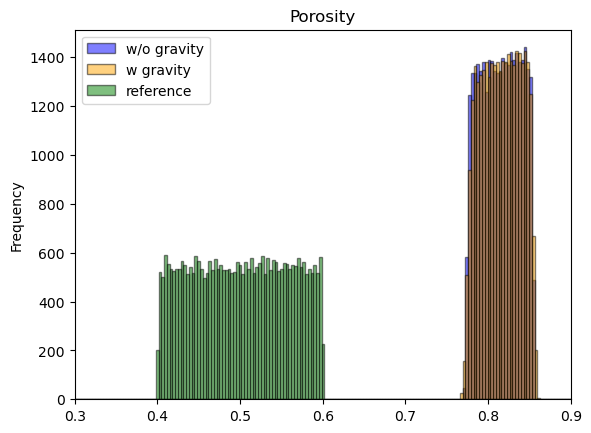

In [36]:
fig, ax = plt.subplots()

width=max-min

ax.bar(porosity_plot, porosity_inhal_g0, color='blue', label='w/o gravity', alpha=0.5, edgecolor='black', width=width) #, label=bar_labels, color=bar_colors)

ax.bar(porosity_plot, porosity_inhal_g, color='orange', label='w gravity', alpha=0.5, edgecolor='black', width=width)

ax.bar(porosity_plot, porosity_ref, color='green', label='reference', alpha=0.5, edgecolor='black', width=width)

ax.set_ylabel('Frequency')
ax.set_title('Porosity')

ax.legend()
# x=numpy.linspace(0,1,2)

# ax.set_xticks()

plt.xlim([0.3, 0.9])

plt.show()